In [ ]:
import numpy as np
import pandas as pd

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydot
import pydotplus
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Models & Processing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

# Tuning of Model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
df = pd.read_csv('https://github.com/tzekiattok/strokedata/blob/main/healthcare-dataset-stroke-data.csv?raw=true')

There is 201 missing value from bmi column. As missing data may led to bias and inaccuracy in results, hence there is a need to handle it. 

In [ ]:
df.info()
#let stroke the the label, (0,1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Remove 'id' column because it is unique and has no meaningful contribution to the model results.

In [ ]:
df.drop('id', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 1. Impute missing values (BMI) with Decision Tree Regressor

The decision tree regressor will analyze the age, gender and bmi of other observations and use that information to predict the value of  the missing bmi based on the age and  gender of the observation.

In [ ]:
DT_bmi_pipe = Pipeline( steps=[ 
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=0))
                              ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age','gender']]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

### 2. OneHotEncode Categorical values

*   Label Encoding - Categorical data with binary response
*   One Hot Encode - Categorical data with more than two types of response


In [ ]:
#Encode values
df_encoded = df
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['gender'], prefix = 'gender=')], axis = 1).drop(['gender'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['ever_married'], prefix = 'ever_married=')], axis = 1).drop(['ever_married'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['work_type'], prefix = 'work_type=')], axis = 1).drop(['work_type'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['Residence_type'], prefix = 'Residence_type=')], axis = 1).drop(['Residence_type'], axis = 1)
df_encoded= pd.concat([df_encoded, pd.get_dummies(df_encoded['smoking_status'], prefix = 'smoking_status=')], axis = 1).drop(['smoking_status'], axis = 1)
df1 = df_encoded
df_encoded.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender=_Female,gender=_Male,gender=_Other,ever_married=_No,ever_married=_Yes,work_type=_Govt_job,work_type=_Never_worked,work_type=_Private,work_type=_Self-employed,work_type=_children,Residence_type=_Rural,Residence_type=_Urban,smoking_status=_Unknown,smoking_status=_formerly smoked,smoking_status=_never smoked,smoking_status=_smokes
0,67.0,0,1,228.69,36.600000,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61.0,0,0,202.21,29.879487,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,79.0,1,0,174.12,24.000000,1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0


### 3. Define X & y

*   y - target variable - stroke 



In [ ]:
X = df1[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married=_No','ever_married=_Yes','work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type=_Rural','Residence_type=_Urban','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male']]
y = df1['stroke']
Columns = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'ever_married=_No','ever_married=_Yes','work_type=_Govt_job','work_type=_Never_worked','work_type=_Private','work_type=_Self-employed','work_type=_children','Residence_type=_Rural','Residence_type=_Urban','smoking_status=_Unknown','smoking_status=_formerly smoked','smoking_status=_never smoked','smoking_status=_smokes','gender=_Female','gender=_Male']

### 4. Train Test Split

*   Use random state=424 to get a standardise results across the different machine learning models
*   Use test size = 0.2 (Commonly split 80-20 for train-test data)
*   Standardise data for variables such as 'avg_glucose_level' that has a different scale from the other variables


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=424)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

### 5. Outlier Removal

*   Remove outliers so that it will not affect the results when performing analysis on random forest

In [ ]:
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1, random_state=424)
yhat = iso.fit_predict(X_train_scaled)

In [ ]:
# select all rows that are not outliers
mask = yhat != -1
X_train, y_train = X_train_scaled[mask], y_train[mask]

In [ ]:
print(X_train.shape, y_train.shape)

(3679, 20) (3679,)


### 6. Apply SMOTE

*   Apply SMOTE only to train data to see how well the model performs in real world using imbalance test data

In [ ]:
rforest = RandomForestClassifier(random_state=424)

smote = SMOTE(random_state=424)

# fit predictor and target variable
X_train_smote, y_train_smote =  smote.fit_resample(X_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_train_smote))

Original dataset shape Counter({0: 3536, 1: 143})
Resample dataset shape Counter({0: 3536, 1: 3536})


### Fit into the model (Random Forest)

*   Train the model
*   Identify the accuracy, precision, recall, f1_score and ROC AUC score for the base model


In [ ]:
rforest = RandomForestClassifier(random_state=424)
rforest.fit(X_train_smote,y_train_smote)
y_pred = rforest.predict(X_test)

conf_matrix_rf = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 

accuracies = cross_val_score(estimator = rforest, X = X_train_smote, y = y_train_smote, cv = 10)   #K-Fold Validation
roc = roc_auc_score(y_test, y_pred)  #ROC AUC Score

print(conf_matrix_rf, '\n Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score,'\n Kfold validation:',accuracies,'\n ROC AUC Score:',roc)

[[909  60]
 [ 45   8]] 
 Accuracy: 0.8972602739726028 
 Precision: 0.11764705882352941 
 Recall: 0.1509433962264151 
 f1_score: 0.1322314049586777 
 Kfold validation: [0.91666667 0.97316384 0.97029703 0.97312588 0.97454031 0.96746818
 0.97171146 0.95473833 0.97736917 0.95898161] 
 ROC AUC Score: 0.5445119457912261


### Tuning hyperparams with GridsearchCV

Find the most optimal parameters that will output the best roc_auc scores.
*   To not overfit the model, use max_depth between 5-8 (commonly used range)

In [ ]:
rf_model = [(
    RandomForestClassifier(),
    [{'n_estimators':[100,200],
      'max_depth':[5, 8],
      'max_features':[8,10,19], 
      'criterion':['gini','entropy'], 'random_state':[424]}])]

In [ ]:
for i,j in rf_model:
    grid = GridSearchCV(estimator=i,param_grid = j, scoring = 'roc_auc',cv = 10)
    grid.fit(X_train_smote, y_train_smote)
    best_param = grid.best_params_
    print('Best Parameters : ',best_param)
    print('')
    print('----------------')
    print('')

Best Parameters :  {'criterion': 'gini', 'max_depth': 8, 'max_features': 8, 'n_estimators': 200, 'random_state': 424}

----------------



Accuracy: 0.7485322896281801 
 Precision: 0.11940298507462686 
 Recall: 0.6037735849056604 
 f1_score: 0.19937694704049844 

              precision    recall  f1-score   support

           0       0.97      0.76      0.85       969
           1       0.12      0.60      0.20        53

    accuracy                           0.75      1022
   macro avg       0.55      0.68      0.53      1022
weighted avg       0.93      0.75      0.82      1022

ROC AUC score: 0.7962497809451488
Accuracy Score:  0.7485322896281801
Balanced Accuracy Score:  0.6801117666530365


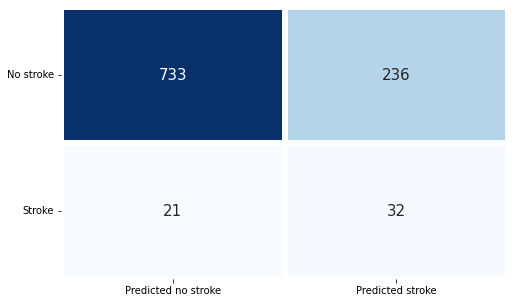

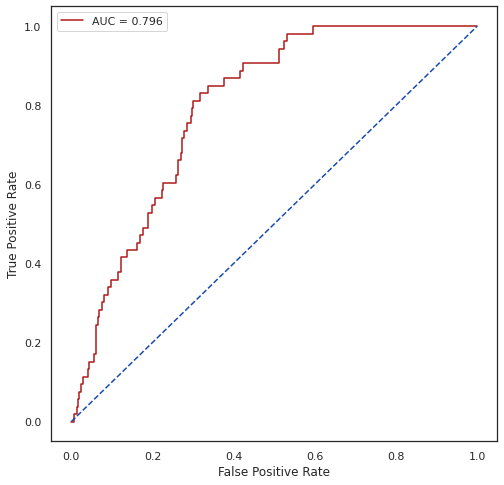

In [ ]:
#Fitting RandomForest Model
rforest = RandomForestClassifier(criterion='gini', max_depth=8, max_features=8, n_estimators=200, random_state=424)
rforest.fit(X_train_smote,y_train_smote)

y_pred = rforest.predict(X_test)
y_prob = rforest.predict_proba(X_test)[:,1]
cm = confusion_matrix(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred) 
recall = metrics.recall_score(y_test, y_pred) 
f1_score = metrics.f1_score(y_test, y_pred) 
print('Accuracy:',
      accuracy,'\n Precision:',  precision,'\n Recall:',  recall,'\n f1_score:',  f1_score, '\n')


print(classification_report(y_test, y_pred))
print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('Balanced Accuracy Score: ',balanced_accuracy_score(y_test, y_pred))

# Visualizing Confusion Matrix
plt.figure(figsize = (8, 5))
sns.heatmap(cm, cmap = 'Blues', annot = True, fmt = 'd', linewidths = 5, cbar = False, annot_kws = {'fontsize': 15}, 
            yticklabels = ['No stroke', 'Stroke'], xticklabels = ['Predicted no stroke', 'Predicted stroke'])
plt.yticks(rotation = 0)
plt.show()

# Roc AUC Curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate,true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()